# CST 383 - Analyzing California's Population Growth & Decline

Authors: Steven Casey, Christopher Varela, Stacy Kirchner, Keldin Maldonado

In this project, we aim to delve into the intricate relationship between violent crime rates and population trends across California's cities and counties over a span from 2000 to 2013. Our investigation seeks to uncover how fluctuations in crime rates influence population dynamics, addressing a critical question: Do rising crime rates lead to population declines as individuals and families seek safer environments, or are there other factors at play? This analysis holds significant value for a broad array of stakeholders, including local law enforcement agencies, policymakers, urban planners, and the general public, by providing evidence-based insights that can inform community safety strategies and urban development policies.

## Choice of Dataset: California Violent Crime Rate Dataset (2000-2013)

Source: California Health and Human Services Agency https://data.ca.gov/dataset/violent-crime-rate

Our analysis is anchored in a comprehensive dataset sourced from the California Health and Human Services Agency. This dataset meticulously documents violent crime rates per 1,000 population, disaggregated by specific types of violent crimes (such as aggravated assault, forcible rape, murder and non-negligent manslaughter, and robbery), across a variety of California localities for the years 2000 to 2013. The inclusion of both numerical and categorical data, alongside detailed stratifications of violent crime categories, renders this dataset particularly suited for exploring the nexus between violent crime rates and changes in population size. This rich dataset not only enables a nuanced understanding of crime patterns but also facilitates a robust analysis of their potential impact on population trends.



## Prediction Goal

The cornerstone of our project is to construct a predictive model that can accurately forecast changes in population sizes within California's cities and counties as a function of violent crime rates. By harnessing data on yearly crime rates, the specific nature of crimes committed, and aggregate violent crime rates, our model endeavors to pinpoint whether an escalation in crime correlates with a discernible exodus of residents, thus suggesting a preference for safer locales. This predictive endeavor aims not just to map out current correlations but to offer a predictive lens through which future trends might be anticipated, thereby equipping stakeholders with a valuable tool for decision-making and strategic planning.

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

df = pd.read_excel("https://data.chhs.ca.gov/dataset/99bc1fea-c55c-4377-bad8-f00832fd195d/resource/bc09f211-200c-4c4c-aa13-d2e89c0d5577/download/hci_crime_752_pl_co_re_ca_2000-2013_21oct15-ada.xlsx")


## Data Preprocessing


### General Overview of Dataset and Issues to Address
Here we get a general overview of what the raw data looks like. Some issues that will be addressed from exploring the values in this data set will be:
- Removing null values
- Removing irrelevant information for our use case
- Providing useful values such as summation of relevant information for our use case

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49227 entries, 0 to 49226
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ind_id                  49227 non-null  object        
 1   ind_definition          49226 non-null  object        
 2   reportyear              49226 non-null  float64       
 3   race_eth_code           49226 non-null  float64       
 4   race_eth_name           49226 non-null  object        
 5   geotype                 49226 non-null  object        
 6   geotypevalue            49226 non-null  float64       
 7   geoname                 49226 non-null  object        
 8   county_fips             48176 non-null  float64       
 9   county_name             48176 non-null  object        
 10  region_code             49156 non-null  float64       
 11  region_name             49156 non-null  object        
 12  strata_name_code        49226 non-null  float6

### Data Cleaning: Dropping Irrelevant Information

In this step, we do data cleaning by dropping columns that are irrelevant for our use case. 

In [18]:
df = df.drop(['ind_id', 'ind_definition', 'race_eth_code', 'race_eth_name', 'strata_name_code', 'strata_name', 'version', 'll_95ci', 'ul_95ci', 'se', 'rse', 'ca_decile', 'ca_rr'], axis=1)

### Filtering Relevant Data
We create a new DataFrame by selecting rows from the original dataset where the "strata_level_name" is specifically "Violent crime total." We are trying to focus our analysis on data specifically related to violent crimes by streamlining the dataset for exploration that is more targeted to that specific category.

In [19]:
df_copy = df
df_copy = df_copy[df_copy['strata_level_name'] == 'Violent crime total']

### Summing Population
The sum of the population ("dof_population") found in each geographic location is added up and calculated. Doing this sum provides us a clear represention of the population for each location. This is useful later when trying to visual the data, or use it for other calculations.

In [20]:
grouped = df_copy.groupby('geoname')
sum_of_pop = grouped['dof_population'].sum()

### Dropping Null Values
Here we are eliminating rows from the DataFrame copy we createe earlier that contain null values, as these are also irrelevant to us. This further enhances the quality of the derived insights.

In [21]:
df_copy.dropna(subset=['rate', 'numerator', 'denominator', 'dof_population'], inplace=True)
#df_copy.dropna(subset=['rate', 'dof_population'], inplace=True)
df_copy['Previous_Denominator'] = df_copy.groupby('geoname')['dof_population'].shift(1)
df_copy['Previous_Denominator'].fillna(0, inplace=True)
df_copy['Pop_Change_Pct'] = (df_copy['dof_population'] / df_copy['Previous_Denominator']) * 100
df_copy.replace([np.inf, -np.inf], 0, inplace=True)
df_copy = df_copy.drop(df_copy[df_copy['rate'] >= 100].index)
df_copy = df_copy.drop(df_copy[df_copy['Pop_Change_Pct'] == 0].index)
df_copy = df_copy.drop(df_copy[df_copy['Pop_Change_Pct'] > 150].index)

C:\Users\steve\AppData\Local\Temp\ipykernel_31960\2408721816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy.dropna(subset=['rate', 'numerator', 'denominator', 'dof_population'], inplace=True)
C:\Users\steve\AppData\Local\Temp\ipykernel_31960\2408721816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Previous_Denominator'] = df_copy.groupby('geoname')['dof_population'].shift(1)
C:\Users\steve\AppData\Local\Temp\ipykernel_31960\2408721816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

## Data Exploration and Visualization:

### Analyzing The Data
After cleaning up the data, we can immediately see issues. One of the issues is that we may need more predictors such as income or race. Perhaps including another dataset that would account for economics or average income would be ideal.

In [22]:
df_copy.describe()

,reportyear,geotypevalue,county_fips,region_code,strata_level_name_code,numerator,denominator,rate,dof_population,Previous_Denominator,Pop_Change_Pct
count,6719.000000,6719.000000,6519.000000,6706.000000,6719.0,6719.000000,6.719000e+03,6719.000000,6.719000e+03,6.719000e+03,6719.000000
mean,2007.007442,37640.290668,6056.335481,8.660304,5.0,1366.730764,2.701125e+05,4.100275,2.698797e+05,2.674777e+05,101.005566
std,3.743718,26931.395792,29.578426,5.113159,0.0,9894.616555,1.894568e+06,3.074385,1.889645e+06,1.873367e+06,2.092248
min,2000.000000,1.000000,6001.000000,1.000000,5.0,1.000000,2.660000e+02,0.024739,2.710000e+02,2.610000e+02,86.165049
25%,2004.000000,10046.000000,6037.000000,4.000000,5.0,39.000000,1.379500e+04,2.025961,1.394750e+04,1.376800e+04,100.036831
50%,2007.000000,36882.000000,6059.000000,10.000000,5.0,119.000000,3.767200e+04,3.503658,3.757400e+04,3.715300e+04,100.583164
75%,2010.000000,60018.000000,6081.000000,14.000000,5.0,349.500000,8.874800e+04,5.369533,8.960950e+04,8.886700e+04,101.320061
max,2013.000000,87056.000000,6115.000000,14.000000,5.0,212831.000000,3.829036e+07,89.247312,3.819386e+07,3.785560e+07,137.465417


### Heatmap
Using a heatmap, these are some of the correlations we found within the data.

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

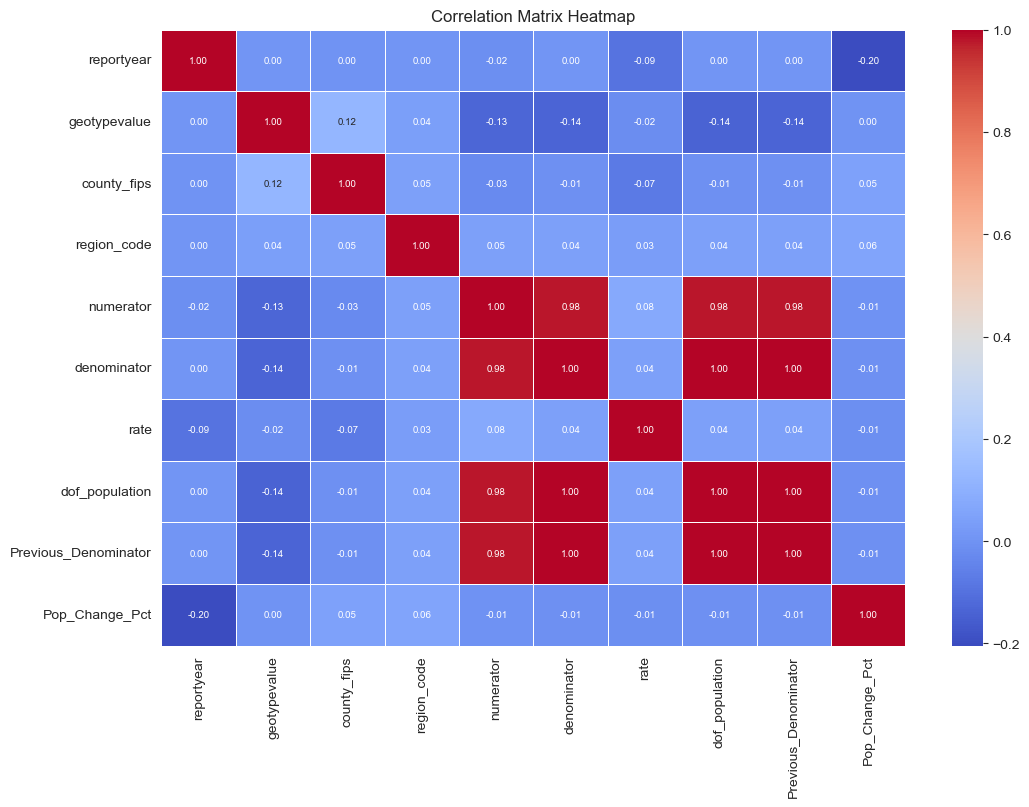

In [23]:
matrix_columns = df_copy.drop('strata_level_name_code', axis=1)
matrix = matrix_columns.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot=True, annot_kws={"size": 7})
plt.title('Correlation Matrix Heatmap')

In [24]:
#sns.pairplot(df_copy)
#plt.show()

## Preliminary Machine Learning Work:

### Predictors & Target

We used two different sets of predictors and target to further explore our hypothesis 

In [25]:
#predictors = ['rate', 'numerator', 'Pop_Change_Pct']
predictors = ['rate']
#target = 'dof_population'
target = 'Pop_Change_Pct'

### Linear Regression

In [26]:
X = df_copy[predictors].values
y = df_copy[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regr = LinearRegression()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
regr.fit(X_train_scaled, y_train)

print('Intercept: {:.2f}'.format(regr.intercept_)) 
print('rate coefficient: {:.3f}'.format(regr.coef_[0])) 
#print('numerator coefficient: {:.3f}'.format(regr.coef_[1])) 
#print('pop_change_pct coefficient: {:.3f}'.format(regr.coef_[2])) 

Intercept: 101.04
rate coefficient: -0.961


Mean Squared Error: 4.664876456623742
Root Mean Squared Error: 2.159832506613358
R-squared: -0.00


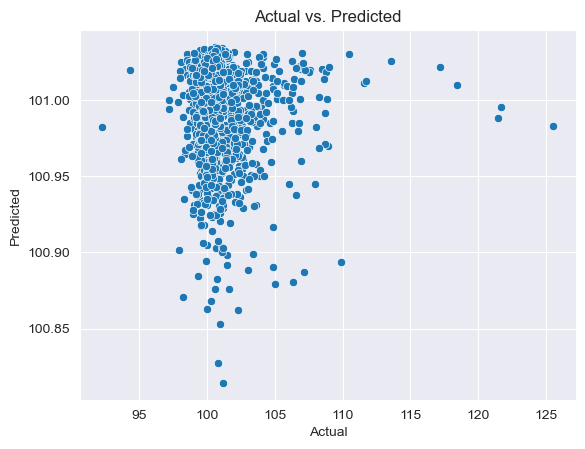

In [27]:
y_pred = regr.predict(X_test_scaled)
mse = ((y_pred - y_test)**2).mean()
rmse = np.sqrt(((y_pred - y_test)**2).mean())
r_score = regr.score(X_test_scaled, y_test)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared: {:.2f}".format(r_score))

sns.scatterplot(x=y_test, y=y_pred)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.show()

### Random Forest 

Mean Squared Error: 7.053586450022356
Root Mean Squared Error: 2.6558588912105923
R-squared: -4.93


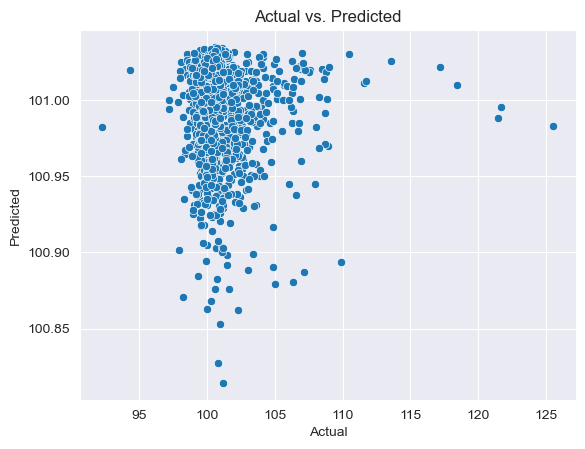

In [28]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.20, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train2, y_train2)

y_pred2 = rf_regressor.predict(X_test2)

mse2 = ((y_pred2 - y_test2)**2).mean()
rmse2 = np.sqrt(((y_pred2 - y_test2)**2).mean())
r_score2 = regr.score(X_test2, y_test2)

print("Mean Squared Error:", mse2)
print("Root Mean Squared Error:", rmse2)
print("R-squared: {:.2f}".format(r_score2)) 
#print('rate coefficient: {:.3f}'.format(rf_regressor.feature_importances_[0]))

sns.scatterplot(x=y_test2, y=y_pred)
#plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.show()

### Polynomial Linear Regression

Mean Squared Error: 4.4825091817868925
Root Mean Squared Error: 2.117193704361245
R-squared: -0.00


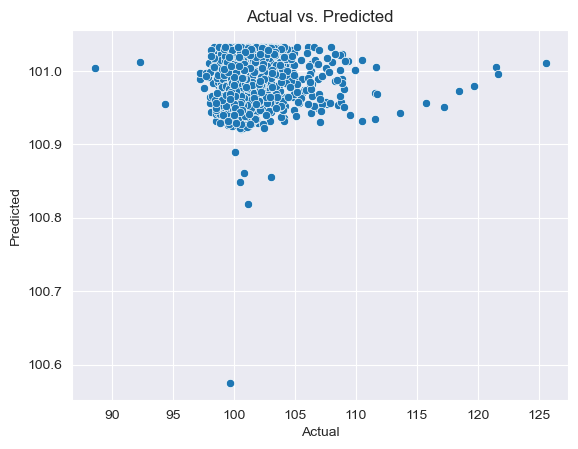

In [29]:
pf = PolynomialFeatures(degree=2, include_bias=False) 
pf.fit(X)

X_poly = pf.transform(X)

X_train3,X_test3, y_train3, y_test3 = train_test_split(X_poly, y, test_size=0.30, random_state=42) 
regr.fit(X_train3, y_train3)

y_pred3 = regr.predict(X_test3)
mse3 = ((y_pred3 - y_test3)**2).mean()
rsme3 = np.sqrt(((y_pred3 - y_test3)**2).mean()) 
r_score3 = regr.score(X_test3, y_test3)

print("Mean Squared Error:", mse3)
print("Root Mean Squared Error:", rsme3)
print("R-squared: {:.2f}".format(r_score3))
#print('rate coefficient: {:.3f}'.format(rf_regressor.feature_importances_[0]))
sns.scatterplot(x=y_test3, y=y_pred3)
#plt.plot([y_test3.min(), y_test3.max()], [y_test3.min(), y_test3.max()], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.show()

### Pop_Change_Pct vs rate

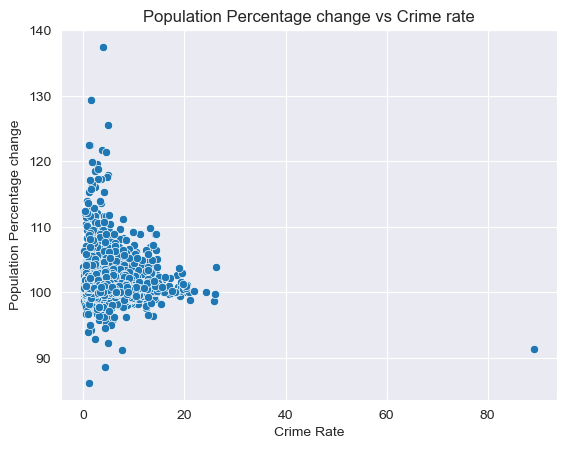

In [30]:
sns.scatterplot(x='rate',y='Pop_Change_Pct', data=df_copy[(df_copy['rate'] < 100) & (df_copy['Pop_Change_Pct'] > 0) & (df_copy['Pop_Change_Pct'] < 150)])
plt.xlabel("Crime Rate")
plt.ylabel("Population Percentage change")
plt.title("Population Percentage change vs Crime rate")
plt.show()